# Preparation of geomagnetic data for Historical Analysis and Machine Learning

This code takes the last 25 years of geomagnetic field measurements from the Fürstenfeldbruck geomagnetic observatory and uses them as a proxy for geomagnetic variations in Austria, specifically at the Conrad Observatory.

### Contents
1. **Read geomagnetic station data**: Read geomagnetic observatory data from Fürstenfeldbruck (FUR) and the Conrad Observatory (WIC) for the years 1995 till 2020. Pack these into dataframes and pickle for easy access later. Also plots all data throughout the years for comparison.
2. **Model geoelectric field and GICs**: Uses the plane wave approach to model the geoelectric field from geomagnetic variations for all years under evaluation. GICs are calculated from a fit of both geoelectric field components to measurements.
3. **Create machine learning feature DataFrame**: Gather all data (including solar wind data) into a single DataFrame to use to train machine learning algorithms.

### Input and Output
- Data (OMNI, INTERMAGNET, etc.) is read from the folder defined in parameters.json "archivepath".
- All pickled DataFrames are stored in the folder defined in parameters.json "datapath".
- Plots are saved to parameters.json "plotpath".

**Author**: Rachel L. Bailey (ZAMG, r.bailey@zamg.ac.at), Dec 2020 - Aug 2021.

In [1]:
import os, sys
from datetime import datetime, timedelta
import json
import matplotlib.pyplot as plt
from matplotlib.dates import num2date, date2num, DateFormatter
import numpy as np
import pandas as pd
import pickle
from scipy.stats import pearsonr
from scipy.optimize import curve_fit
import time

# GeomagPy is used for reading INTERMAGNET data
import magpy as mp
import seaborn as sns
from sklearn.metrics import mean_squared_error

# Local functions
import sw2gic

Problems with identfying cron job - windows system?
/Users/rbailey/miniconda3/envs/lstm-env-backup/lib/python3.8/site-packages/magpy/stream.py:185: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  matplotlib.use(gui, warn=False, force=True)


## 1. Read geomagnetic station data

This analysis uses data from two geomagnetic observatories: 
- Fürstenfeldbruck (FUR) in Bavaria, Germany (years 1995-2021),
- the Conrad Observatory (WIC) in Austria (years 2016-2021).

The FUR and WIC datasets were downloaded in IAGA-2002 minute format from INTERMAGNET: https://intermagnet.org/data-donnee/download-eng.php

In [2]:
with open('parameters.json', 'r') as fp:
    Params = json.load(fp)
# Local archive path to INTERMAGNET data:
archive_path = Params['archivepath']
# Data save paths
data_path = Params['datapath']
plot_path = Params['plotpath']
# Periods covered
readyears_FUR = [1995, 2021]
readyears_WIC = [2015, 2021]

### Read FUR data

In [3]:
pickled_data_path_FUR = os.path.join(data_path, "all_fur_data.p")

if not os.path.exists(pickled_data_path_FUR):
    # This is a lot of data. Read by year to ease the load
    for year in range(readyears_FUR[0],readyears_FUR[1]):
        fur_path = os.path.join(archive_path, 'FUR', 'INTERMAGNET', 'fur{}*'.format(year))
        print("Reading year {} from {}...".format(year, fur_path))
        data = mp.read(fur_path)
        if year == readyears_FUR[0]:
            df_time = [num2date(x).replace(tzinfo=None) for x in data['time']]
            data_F = np.sqrt(data['x']**2. + data['y']**2. + data['z']**2.)
            df_FUR = pd.DataFrame({'time': df_time, 'Bx': data['x'], 'By': data['y'], 'Bz': data['z'], 'F': data_F})
            df_FUR = df_FUR.set_index('time')
        else:
            df_time = [num2date(x).replace(tzinfo=None) for x in data['time']]
            data_F = np.sqrt(data['x']**2. + data['y']**2. + data['z']**2.)
            df_temp = pd.DataFrame({'time': df_time, 'Bx': data['x'], 'By': data['y'], 'Bz': data['z'], 'F': data_F})
            df_temp = df_temp.set_index('time')
            df_FUR = pd.concat([df_FUR, df_temp], axis=0)
    df_FUR.to_pickle(pickled_data_path_FUR)
else:
    df_FUR = pd.read_pickle(pickled_data_path_FUR)
df_FUR

,Bx,By,Bz,F
time,,,,
1995-01-01 00:00:00,20821.00,151.00,42843.00,47634.645910
1995-01-01 00:01:00,20821.00,151.00,42843.00,47634.645910
1995-01-01 00:02:00,20821.00,151.00,42843.00,47634.645910
1995-01-01 00:03:00,20821.00,151.00,42843.00,47634.645910
1995-01-01 00:04:00,20821.00,150.00,42843.00,47634.642751
...,...,...,...,...
2020-12-31 23:55:00,20987.26,1315.00,43738.01,48530.483472
2020-12-31 23:56:00,20986.84,1315.16,43738.05,48530.342228
2020-12-31 23:57:00,20986.84,1315.01,43738.09,48530.374214


#### Tidy up the data

In [4]:
# Remove (most) bad data values
# -----------------------------
orig_len = len(df_FUR)
print("Size of data:\t{}".format(orig_len))
# Drop bad data areas:
df_FUR.drop(df_FUR.loc[df_FUR[datetime(2020,10,6):datetime(2020,10,8)].index].index, inplace=True)
df_FUR.drop(df_FUR.loc[df_FUR[datetime(2016,3,27,2):datetime(2016,3,27,4)].index].index, inplace=True)
df_FUR.drop(df_FUR.loc[df_FUR[datetime(2020,11,3,10):datetime(2020,11,4)].index].index, inplace=True)
# Remove data with invalid values of F:
df_FUR = df_FUR.loc[df_FUR['F'] > 40000.]
new_len = len(df_FUR)
print("Removing {:.1f}% of data with bad F (< 40000 nT) values.".format(100.*(orig_len-new_len)/orig_len))
# Remove data with filler values:
df_FUR = df_FUR.loc[df_FUR['Bz'] != 43000.]
df_FUR = df_FUR.loc[((df_FUR['Bx'] != 20000.) & (df_FUR['Bz'] != 42000.))]
print("Removing {:.2f}% of data with filler values.".format(100.*(new_len-len(df_FUR))/new_len))
new_len = len(df_FUR)
# Remove duplicates:
df_FUR = df_FUR[~df_FUR.index.duplicated()]
print("Removing {:.2f}% of duplicate data.".format(100.*(new_len-len(df_FUR))/new_len))
print("Final size:  \t{}".format(len(df_FUR)))

# Find data gaps where dt > 300s (5 minutes)
# ------------------------------------------
df_FUR['Data_Gap'] = (df_FUR.index.to_series().diff()).dt.total_seconds() > 300
# Set dB/dt to zero as these values are otherwise incorrect
for bval in ['x', 'y', 'z']:
    df_FUR['dB{}/dt'.format(bval)] = np.diff(df_FUR['B'+bval], prepend=df_FUR['B'+bval][0])
    # Remove dB/dt values from larger data gaps:
    df_FUR.loc[df_FUR['Data_Gap'] == True,'dB{}/dt'.format(bval)] = 0
data_cols = list(df_FUR.columns)
data_cols.remove('Data_Gap')
# Save this cleaned version for the historical analysis:
df_FUR.to_pickle(os.path.join(data_path, "all_fur_data_clean.p"))

Size of data:	13672800
Removing 0.2% of data with bad F (< 40000 nT) values.
Removing 0.01% of data with filler values.
Removing 0.02% of duplicate data.
Final size:  	13646728


### Read WIC data

In [5]:
pickled_data_path_WIC = os.path.join(data_path, "all_wic_data.p")

if not os.path.exists(pickled_data_path_WIC):
    for year in range(readyears_WIC[0],readyears_WIC[1]):
        wic_path = os.path.join(archive_path, 'WIC', 'INTERMAGNET', 'wic{}*'.format(year))
        print("Reading year {} from {}...".format(year, wic_path))
        data = mp.read(wic_path)
        if year == readyears_WIC[0]:
            df_time = [num2date(x).replace(tzinfo=None) for x in data['time']]
            data_F = np.sqrt(data['x']**2. + data['y']**2. + data['z']**2.)
            df_WIC = pd.DataFrame({'time': df_time, 'Bx': data['x'], 'By': data['y'], 'Bz': data['z'], 'F': data_F})
            df_WIC = df_WIC.set_index('time')
        else:
            df_time = [num2date(x).replace(tzinfo=None) for x in data['time']]
            data_F = np.sqrt(data['x']**2. + data['y']**2. + data['z']**2.)
            df_temp = pd.DataFrame({'time': df_time, 'Bx': data['x'], 'By': data['y'], 'Bz': data['z'], 'F': data_F})
            df_temp = df_temp.set_index('time')
            df_WIC = pd.concat([df_WIC, df_temp], axis=0)
    df_WIC.to_pickle(pickled_data_path_WIC)
else:
    df_WIC = pd.read_pickle(pickled_data_path_WIC)
df_WIC

,Bx,By,Bz,F
time,,,,
2015-01-01 00:00:00,20989.40,1377.00,43659.10,48462.026930
2015-01-01 00:01:00,20989.40,1376.80,43659.20,48462.111337
2015-01-01 00:02:00,20989.50,1376.50,43659.20,48462.146126
2015-01-01 00:03:00,20989.40,1376.20,43659.30,48462.184384
2015-01-01 00:04:00,20989.40,1376.00,43659.30,48462.178705
...,...,...,...,...
2020-12-31 23:55:00,21005.85,1690.65,43969.45,48758.758854
2020-12-31 23:56:00,21005.51,1690.79,43969.47,48758.635269
2020-12-31 23:57:00,21005.52,1690.64,43969.48,48758.643393


#### Tidy up the data

In [6]:
# Remove (most) bad data values
# -----------------------------
orig_len = len(df_WIC)
print("Size of data:\t{}".format(orig_len))
# Drop bad data areas:
df_WIC.drop(df_WIC.loc[df_WIC[datetime(2016,3,27,2):datetime(2016,3,27,4)].index].index, inplace=True)
# Remove data with invalid values of F:
df_WIC = df_WIC.loc[df_WIC['F'] > 40000.]
new_len = len(df_WIC)
print("Removing {:.1f}% of data with bad F (< 40000 nT) values.".format(100.*(orig_len-new_len)/orig_len))
# Remove data with filler values:
df_WIC = df_WIC.loc[df_WIC['Bz'] != 43000.]
df_WIC = df_WIC.loc[((df_WIC['Bx'] != 20000.) & (df_WIC['Bz'] != 42000.))]
print("Removing {:.2f}% of data with filler values.".format(100.*(new_len-len(df_WIC))/new_len))
new_len = len(df_WIC)
# Remove duplicates:
df_WIC = df_WIC[~df_WIC.index.duplicated()]
print("Removing {:.2f}% of duplicate data.".format(100.*(new_len-len(df_WIC))/new_len))
print("Final size:  \t{}".format(len(df_WIC)))

# Find data gaps where dt > 300s (5 minutes)
# ------------------------------------------
df_WIC['Data_Gap'] = (df_WIC.index.to_series().diff()).dt.total_seconds() > 300
# Set dB/dt to zero as these values are otherwise incorrect
for bval in ['x', 'y', 'z']:
    df_WIC['dB{}/dt'.format(bval)] = np.diff(df_WIC['B'+bval], prepend=df_WIC['B'+bval][0])
    # Remove dB/dt values from larger data gaps:
    df_WIC.loc[df_WIC['Data_Gap'] == True,'dB{}/dt'.format(bval)] = 0
data_cols = list(df_WIC.columns)
data_cols.remove('Data_Gap')
# Save this cleaned version for the historical analysis:
df_WIC.to_pickle(os.path.join(data_path, "all_wic_data_clean.p"))

Size of data:	3146400
Removing 0.6% of data with bad F (< 40000 nT) values.
Removing 0.00% of data with filler values.
Removing 0.01% of duplicate data.
Final size:  	3127220


## 2. Model the geoelectric field and GICs

Use the plane wave approach and a 1D layered half-space describing the subsurface conductivity of Austria to model the geoelectric field induced in the ground by geomagnetic variations.

In [7]:
all_magdata_path_FUR = os.path.join(data_path, "bfield_fur_{}-{}.txt".format(readyears_FUR[0], readyears_FUR[1]))
all_magdata_path_WIC = os.path.join(data_path, "bfield_wic_{}-{}.txt".format(readyears_WIC[0], readyears_WIC[1]))

all_efield_path_FUR = os.path.join(data_path, "efield_fur_39_{}-{}.txt".format(readyears_FUR[0], readyears_FUR[1]))
all_efield_path_WIC = os.path.join(data_path, "efield_wic_39_{}-{}.txt".format(readyears_WIC[0], readyears_WIC[1]))

#### E-field from FUR data

In [8]:
start_e_calc = time.time()

# Calculate geoelectric field:
print("Calculating E-field from FUR B-field data...")
resistivities = np.array([1000, 300, 1000])
thicknesses = np.array([55000, 45000])

# Tidy up magnetic field data and save:
mag_x, mag_y = sw2gic.prepare_B_for_E_calc(df_FUR)
Bh_t = np.vstack((mag_x, mag_y))
with open(all_magdata_path_FUR, 'wb') as f:
    np.save(f, Bh_t, allow_pickle=False)

# Calculate geoelectric field:
Ex_t, Ey_t = sw2gic.calc_E_using_plane_wave_method(mag_x, mag_y, resistivities, thicknesses)
E_t = np.vstack((Ex_t, Ey_t))
end_e_calc = time.time()

print("    Original MAG data size: {}".format(len(df_FUR['Bx'])))
print("    New MAG data size:      {}".format(len(mag_x)))
print("Full E-field calculation took {:.1f} seconds.".format(end_e_calc - start_e_calc))

with open(all_efield_path_FUR, 'wb') as f:
    np.save(f, E_t, allow_pickle=False)

print("Done.")
#E_t = np.load(all_efield_path_FUR)

Calculating E-field from FUR B-field data...
    Original MAG data size: 13646728
    New MAG data size:      13675680
Full E-field calculation took 53.7 seconds.
Done.


#### E-field from WIC data

In [9]:
start_e_calc = time.time()

# Tidy up magnetic field data and save:
mag_x, mag_y = sw2gic.prepare_B_for_E_calc(df_WIC)
Bh_t_WIC = np.vstack((mag_x, mag_y))
with open(all_magdata_path_WIC, 'wb') as f:
    np.save(f, Bh_t_WIC, allow_pickle=False)
print("    Original MAG data size: {}".format(len(df_WIC['Bx'])))
print("    New MAG data size:      {}".format(len(mag_x)))

# Calculate geoelectric field:
for layermodel in ['03', '16', '39', '55']:
    print("Calculating E-field from WIC B-field data with layer model #{}...".format(layermodel))
    resistivities = np.array([1000, 300, 1000])
    thicknesses = np.array([55000, 45000])

    # Calculate geoelectric field:
    Ex_t_WIC, Ey_t_WIC = sw2gic.calc_E_using_plane_wave_method(mag_x, mag_y, resistivities, thicknesses)
    E_t_WIC = np.vstack((Ex_t_WIC, Ey_t_WIC))
    end_e_calc = time.time()

    all_efield_path_WIC = os.path.join(data_path, "efield_wic_{}_{}-{}.txt".format(layermodel, 
                                                                                   readyears_WIC[0], readyears_WIC[1]))
    with open(all_efield_path_WIC, 'wb') as f:
        np.save(f, E_t_WIC, allow_pickle=False)
print("Full E-field calculation took {:.1f} seconds.".format(end_e_calc - start_e_calc))
print("Done.")

wic_efield_path = os.path.join(data_path, "efield_wic_39_{}-{}.txt".format(readyears_WIC[0], readyears_WIC[1]))
E_t_WIC = np.load(wic_efield_path)

    Original MAG data size: 3127220
    New MAG data size:      3156480
Calculating E-field from WIC B-field data with layer model #03...
Calculating E-field from WIC B-field data with layer model #16...
Calculating E-field from WIC B-field data with layer model #39...
Calculating E-field from WIC B-field data with layer model #55...
Full E-field calculation took 19.7 seconds.
Done.


### Find fits for calculating GICs for two stations

The GICs at substations are primarily a linear combination of Ex and Ey:

![\Large GIC={a}\cdot{E_x}+{b}\cdot{E_y}](https://latex.codecogs.com/svg.latex?GIC={a}\cdot{E_x}+{b}\cdot{E_y})

Since we have both GIC measurements and geoelectric field components, we can do a simple linear fit to the measurement data to find the best values of _a_ and _b_. This is carried out for two substations: SS1 and SS5. Three periods are selected: two storms (Sept 2017 and May 2021), and one longer period of moderate activity (Sept 2020). The fit is done on these periods only rather than on the whole dataset to avoid signals caused by noise, which make up a large part of the lower-amplitude GICs.

**A note on the measurements**: There is a cut-off in the positive direction at around 3.4 A, so we only fit to measurements that are below this level or we'll be applying a fit to unrepresentative data. (This cut-off value is no longer present from 2021 onwards.) There is no maximum cut-off value in the negative direction to account for.

In [18]:
# Load geomagnetic field data from 2021 (which is otherwise not used in this analysis):
print("Reading WIC 2021 data...")
wic_path = os.path.join(archive_path, 'WIC', 'INTERMAGNET', 'wic2021*')
data = mp.read(wic_path)
df_time_2021 = [num2date(x).replace(tzinfo=None) for x in data['time']]
df_WIC_2021 = pd.DataFrame({'time': df_time_2021, 'Bx': data['x'], 'By': data['y']})
df_WIC_2021 = df_WIC_2021.set_index('time')

print("Reading FUR 2021 data...")
fur_path = os.path.join(archive_path, 'FUR', 'INTERMAGNET', 'fur2021*')
data = mp.read(fur_path)
df_time_FUR_2021 = [num2date(x).replace(tzinfo=None) for x in data['time']]
df_FUR_2021 = pd.DataFrame({'time': df_time_FUR_2021, 'Bx': data['x'], 'By': data['y']})
df_FUR_2021 = df_FUR_2021.set_index('time')

# Calculate geoelectric field:
mag_x, mag_y = sw2gic.prepare_B_for_E_calc(df_WIC_2021)
mag_x_FUR, mag_y_FUR = sw2gic.prepare_B_for_E_calc(df_FUR_2021)
Ex_t_2021, Ey_t_2021 = sw2gic.calc_E_using_plane_wave_method(mag_x, mag_y, resistivities, thicknesses)
E_t_2021 = np.vstack((Ex_t_2021, Ey_t_2021))
Ex_t_FUR_2021, Ey_t_FUR_2021 = sw2gic.calc_E_using_plane_wave_method(mag_x_FUR, mag_y_FUR, resistivities, thicknesses)
E_t_FUR_2021 = np.vstack((Ex_t_FUR_2021, Ey_t_FUR_2021))

# Load all GIC measurements (compiled beforehand):
df_gic_meas = pd.read_pickle(os.path.join(data_path, 'df_gic_meas.p'))
print("Done.")

Reading WIC 2021 data...
Reading FUR 2021 data...
Done.


In [20]:
# Period #1: Sept 2017 storm
p1_start, p1_end = datetime(2017,9,7), datetime(2017,9,9,12)
p1_active = [datetime(2017,9,7,20), datetime(2017,9,8,23)]
E_p1 = sw2gic.extract_time_from_pos(E_t_WIC, p1_start, p1_end, zero_time=datetime(2015,1,1), axis=1)
E_FUR_p1 = sw2gic.extract_time_from_pos(E_t, p1_start, p1_end, axis=1)
gic_SS1_1 = df_gic_meas.loc[p1_start:p1_end-timedelta(minutes=1), 'GIC_SS1'].to_numpy()
gic_SS5_1 = df_gic_meas.loc[p1_start:p1_end-timedelta(minutes=1), 'GIC_SS5'].to_numpy()
t_p1 = df_gic_meas[p1_start:p1_end-timedelta(minutes=1)].index

# Period #2: Sept 2020 activity
p2_start, p2_end = datetime(2020,9,27), datetime(2020,10,1,4)
p2_active = [datetime(2020,9,27,16), datetime(2020,9,30,4)]
E_p2 = sw2gic.extract_time_from_pos(E_t_WIC, p2_start, p2_end, zero_time=datetime(2015,1,1), axis=1)
E_FUR_p2 = sw2gic.extract_time_from_pos(E_t, p2_start, p2_end, axis=1)
gic_SS1_2 = df_gic_meas.loc[p2_start:p2_end-timedelta(minutes=1), 'GIC_SS1'].to_numpy()
gic_SS5_2 = df_gic_meas.loc[p2_start:p2_end-timedelta(minutes=1), 'GIC_SS5'].to_numpy()
t_p2 = df_gic_meas[p2_start:p2_end-timedelta(minutes=1)].index

# Period #3: March 2021 storm
p3_start, p3_end = datetime(2021,5,11,12), datetime(2021,5,13,12)
p3_active = [datetime(2021,5,12,4), datetime(2021,5,13,2)]
E_p3 = sw2gic.extract_time_from_pos(E_t_2021, p3_start, p3_end, zero_time=datetime(2021,1,1), axis=1)
E_FUR_p3 = sw2gic.extract_time_from_pos(E_t_FUR_2021, p3_start, p3_end, zero_time=datetime(2021,1,1), axis=1)
gic_SS1_3 = df_gic_meas.loc[p3_start:p3_end-timedelta(minutes=1), 'GIC_SS1'].to_numpy()
gic_SS5_3 = df_gic_meas.loc[p3_start:p3_end-timedelta(minutes=1), 'GIC_SS5'].to_numpy()
t_p3 = df_gic_meas[p3_start:p3_end-timedelta(minutes=1)].index

gic_SS1 = np.hstack((gic_SS1_1, gic_SS1_2, gic_SS1_3))
gic_SS5 = np.hstack((gic_SS5_1, gic_SS5_2, gic_SS5_3))

t_all = np.hstack((t_p1, t_p2, t_p3))
plot_all = np.array([date2num(t_p1[0] + timedelta(minutes=int(x))) for x in np.arange(len(t_all))])
E_all = np.hstack((E_p1, E_p2, E_p3))
E_FUR_all = np.hstack((E_FUR_p1, E_FUR_p2, E_FUR_p3))

# Define periods of activity to use for fit
p1_inds_active = np.where(np.logical_and(t_p1 > p1_active[0], t_p1 < p1_active[1]))[0]
p2_inds_active = np.where(np.logical_and(t_p2 > p2_active[0], t_p2 < p2_active[1]))[0] + len(t_p1)
p3_inds_active = np.where(np.logical_and(t_p3 > p3_active[0], t_p3 < p3_active[1]))[0] + len(t_p1) + len(t_p2)
inds_active = np.hstack((p1_inds_active, p2_inds_active, p3_inds_active))

# Only use values below cut-off value (but not for 2021, where max. limit has been removed)
cutoff_level = 3.2
in_bounds_SS1 = np.hstack((np.where(gic_SS1[:len(t_p1)+len(t_p2)+2] < cutoff_level)[0], p3_inds_active))
inds_SS1 = np.intersect1d(in_bounds_SS1, inds_active)
in_bounds_SS5 = np.hstack((np.where(gic_SS5[:len(t_p1)+len(t_p2)+2] < cutoff_level)[0], p3_inds_active))
inds_SS5 = np.intersect1d(in_bounds_SS5, inds_active)

print("Length of GIC data:      {}".format(len(gic_SS1)))
print("Length of E-field data:  {}".format(len(E_all[0])))
print("Points used for SS1 fit: {}".format(len(inds_SS1)))
print("Points used for SS5 fit: {}".format(len(inds_SS5)))

Length of GIC data:      12480
Length of E-field data:  12480
Points used for SS1 fit: 6515
Points used for SS5 fit: 6508


#### Substation #1 - SS1

GIC_SS1 = 0.04062 * Ex + 0.02633 * Ey
    X/Y = 1.54, Y/X = 0.65
GIC_SS1 = 0.03770 * Ex_FUR + 0.03190 * Ey_FUR
    X/Y = 1.18, Y/X = 0.85

RMSE_fit = 0.117
CORR_fit = 0.860
RMSE_fit_FUR = 0.121
CORR_fit_FUR = 0.861


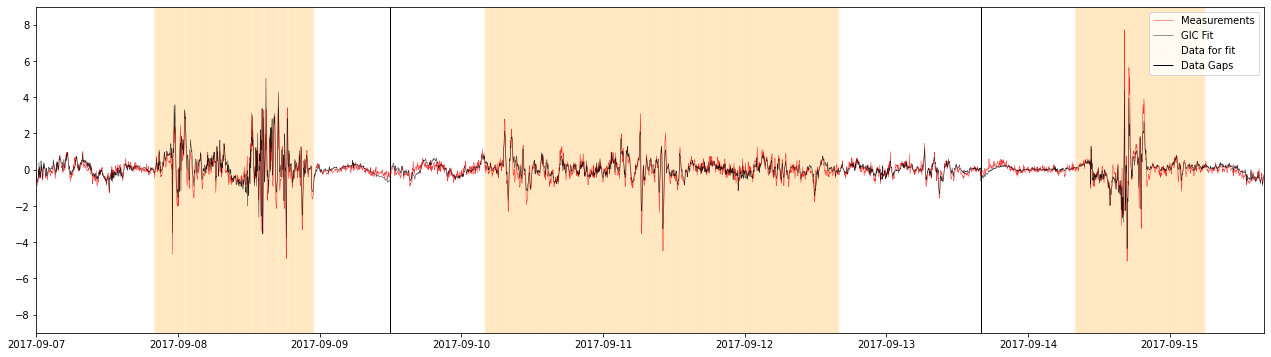

In [21]:
%matplotlib inline
a_SS1, b_SS1 = sw2gic.calc_ab_for_GIC_from_E(E_all[0,inds_SS1], E_all[1,inds_SS1], gic_SS1[inds_SS1])
a_SS1_FUR, b_SS1_FUR = sw2gic.calc_ab_for_GIC_from_E(E_FUR_all[0,inds_SS1], E_FUR_all[1,inds_SS1], gic_SS1[inds_SS1])
y = E_all[0] * a_SS1 + E_all[1] * b_SS1
y_FUR = E_FUR_all[0] * a_SS1_FUR + E_FUR_all[1] * b_SS1_FUR
print("GIC_SS1 = {:.5f} * Ex + {:.5f} * Ey\n    X/Y = {:.2f}, Y/X = {:.2f}".format(a_SS1, b_SS1, a_SS1/b_SS1, b_SS1/a_SS1))
print("GIC_SS1 = {:.5f} * Ex_FUR + {:.5f} * Ey_FUR\n    X/Y = {:.2f}, Y/X = {:.2f}".format(
    a_SS1_FUR, b_SS1_FUR, a_SS1_FUR/b_SS1_FUR, b_SS1_FUR/a_SS1_FUR))
print("")
print("RMSE_fit = {:.3f}".format(mean_squared_error(y[~np.isnan(gic_SS1)], gic_SS1[~np.isnan(gic_SS1)])))
print("CORR_fit = {:.3f}".format(pearsonr(y[~np.isnan(gic_SS1)], gic_SS1[~np.isnan(gic_SS1)])[0]))
print("RMSE_fit_FUR = {:.3f}".format(mean_squared_error(y_FUR[~np.isnan(gic_SS1)], gic_SS1[~np.isnan(gic_SS1)])))
print("CORR_fit_FUR = {:.3f}".format(pearsonr(y_FUR[~np.isnan(gic_SS1)], gic_SS1[~np.isnan(gic_SS1)])[0]))

skip = 3
fig = plt.figure(figsize=(22,6))
plt.plot_date(plot_all[::skip], gic_SS1[::skip], 'r-', lw=0.5, alpha=0.8, label="Measurements")
plt.plot_date(plot_all[::skip], y[::skip], 'k-', lw=0.5, alpha=0.8, label="GIC Fit")
plt.vlines(plot_all[inds_SS1], ymin=-10, ymax=10, lw=0.2, alpha=0.1, color='orange', label="Data for fit")
pos_data_gaps = np.array([len(t_p1), len(t_p1)+len(t_p2)])
plt.vlines(plot_all[pos_data_gaps], ymin=-10, ymax=10, lw=1, color='black', label="Data Gaps")
plt.legend()
plt.xlim((plot_all[0], plot_all[-1]))
plt.ylim((-9,9))
plt.show()

#### Substation #2 - SS5

GIC_SS5 = 0.00893 * Ex + 0.05263 * Ey
    X/Y = 0.17, Y/X = 5.90
GIC_SS5 = 0.00444 * Ex_FUR + 0.05552 * Ey_FUR
    X/Y = 0.08, Y/X = 12.51

RMSE_fit = 0.110
CORR_fit = 0.884
RMSE_fit_FUR = 0.118
CORR_fit_FUR = 0.875


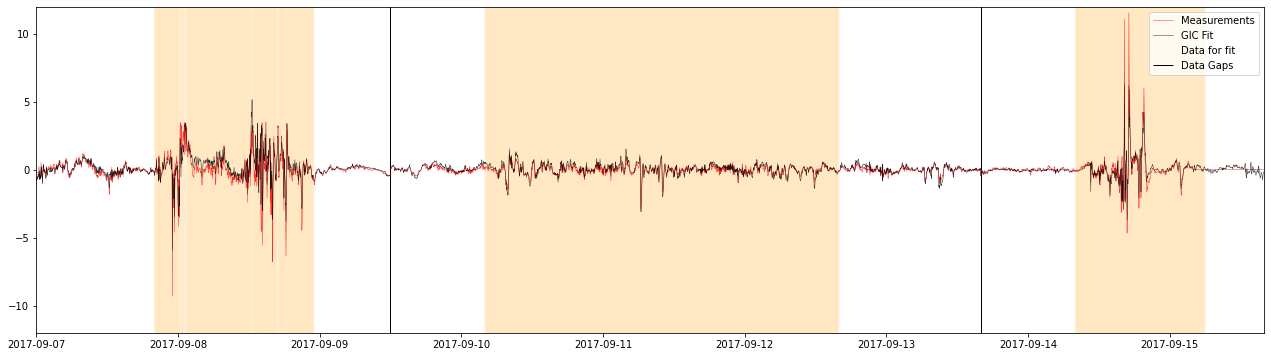

In [22]:
%matplotlib inline
a_SS5, b_SS5 = sw2gic.calc_ab_for_GIC_from_E(E_all[0,inds_SS5], E_all[1,inds_SS5], gic_SS5[inds_SS5])
a_SS5_FUR, b_SS5_FUR = sw2gic.calc_ab_for_GIC_from_E(E_FUR_all[0,inds_SS5], E_FUR_all[1,inds_SS5], gic_SS5[inds_SS5])
y = E_all[0] * a_SS5 + E_all[1] * b_SS5
y_FUR = E_FUR_all[0] * a_SS5_FUR + E_FUR_all[1] * b_SS5_FUR
print("GIC_SS5 = {:.5f} * Ex + {:.5f} * Ey\n    X/Y = {:.2f}, Y/X = {:.2f}".format(a_SS5, b_SS5, a_SS5/b_SS5, b_SS5/a_SS5))
print("GIC_SS5 = {:.5f} * Ex_FUR + {:.5f} * Ey_FUR\n    X/Y = {:.2f}, Y/X = {:.2f}".format(
    a_SS5_FUR, b_SS5_FUR, a_SS5_FUR/b_SS5_FUR, b_SS5_FUR/a_SS5_FUR))
print("")
print("RMSE_fit = {:.3f}".format(mean_squared_error(y[~np.isnan(gic_SS5)], gic_SS5[~np.isnan(gic_SS5)])))
print("CORR_fit = {:.3f}".format(pearsonr(y[~np.isnan(gic_SS5)], gic_SS5[~np.isnan(gic_SS5)])[0]))
print("RMSE_fit_FUR = {:.3f}".format(mean_squared_error(y_FUR[~np.isnan(gic_SS5)], gic_SS5[~np.isnan(gic_SS5)])))
print("CORR_fit_FUR = {:.3f}".format(pearsonr(y_FUR[~np.isnan(gic_SS5)], gic_SS5[~np.isnan(gic_SS5)])[0]))

skip = 3
fig = plt.figure(figsize=(22,6))
plt.plot_date(plot_all[::skip], gic_SS5[::skip], 'r-', lw=0.5, alpha=0.8, label="Measurements")
plt.plot_date(plot_all[::skip], y[::skip], 'k-', lw=0.5, alpha=0.8, label="GIC Fit")
plt.vlines(plot_all[inds_SS5], ymin=-15, ymax=15, lw=0.2, alpha=0.1, color='orange', label="Data for fit")
pos_data_gaps = np.array([len(t_p1), len(t_p1)+len(t_p2)])
plt.vlines(plot_all[pos_data_gaps], ymin=-15, ymax=15, lw=1, color='black', label="Data Gaps")
#plt.scatter(t_event[t_inds_SS5_out], gic_SS5[t_inds_SS5_out], 'x')#, ymin=-10, ymax=10, lw=1, alpha=0.2, color='purple', label="Excluded data")
plt.legend()
plt.xlim((plot_all[0], plot_all[-1]))
plt.ylim((-12,12))
plt.show()

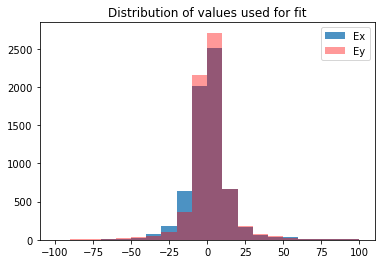

In [23]:
plt.hist(E_all[0,inds_SS5], bins=20, range=(-100,100), alpha=0.8, label="Ex")
plt.hist(E_all[1,inds_SS5], bins=20, range=(-100,100), fc='red', alpha=0.4, label="Ey")
plt.legend()
plt.title("Distribution of values used for fit")
plt.show()

#### Plot maps of locations and example GIC fit

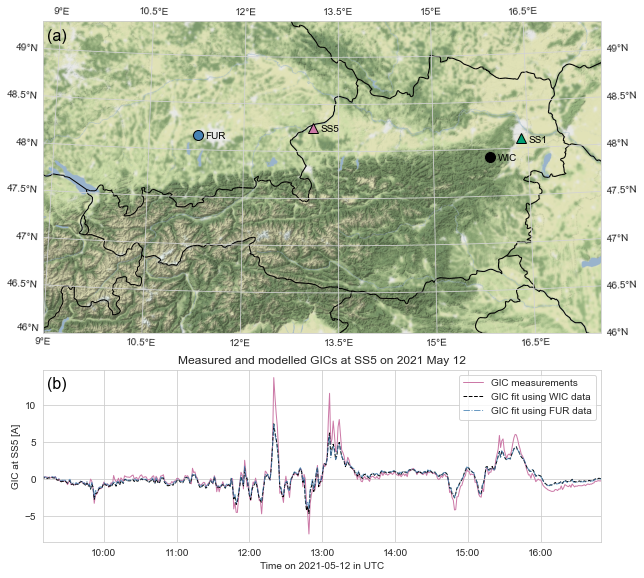

In [25]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
from matplotlib.dates import DateFormatter
import cartopy.io.img_tiles as cimgt

sns.set_style(Params["sns_style"])

c_fur = 'steelblue'
c_wic = 'k'
c_SS1, c_SS5 = Params['c_SS1'], Params['c_SS5']

fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(3, 3)
gs_split = 2

stamen_terrain = cimgt.Stamen('terrain-background')

proj = ccrs.TransverseMercator(13.4, approx=True) #ccrs.EuroPP()
#proj = ccrs.PlateCarree(central_longitude=13)
ax1 = fig.add_subplot(gs[0:gs_split, :], projection=proj)
ax1.set_extent([9, 17.5, 46, 49.3], crs=ccrs.PlateCarree())
ax1.add_feature(cfeature.BORDERS)
ax1.add_image(stamen_terrain, 8)
ax1.gridlines(color='lightgrey', linestyle='-', draw_labels=True)

# PLOT MARKERS
lat_off, lon_off = -0.04, 0.11
c_text = 'k'
xy_FUR, xy_WIC = [11.28, 48.16], [15.90, 47.92]
ax1.plot(xy_WIC[0], xy_WIC[1], markersize=10, marker='o', color=c_wic, lw=0, transform=ccrs.Geodetic())
ax1.text(xy_WIC[0]+lon_off, xy_WIC[1]+lat_off, 'WIC', color=c_text, transform=ccrs.Geodetic())
ax1.plot(xy_FUR[0], xy_FUR[1], markersize=10, marker='o', color=c_fur, lw=0, markeredgecolor='k', transform=ccrs.Geodetic())
ax1.text(xy_FUR[0]+lon_off, xy_FUR[1]+lat_off, 'FUR', color=c_text, transform=ccrs.Geodetic())

ax1.plot(xy_SS1[0], xy_SS1[1], markersize=10, marker='^', color=c_SS1, lw=0, markeredgecolor='k', transform=ccrs.Geodetic())
ax1.text(xy_SS1[0]+lon_off, xy_SS1[1]+lat_off, 'SS1', color=c_text, transform=ccrs.Geodetic())
ax1.plot(xy_SS5[0], xy_SS5[1], markersize=10, marker='^', color=c_SS5, lw=0, markeredgecolor='k', transform=ccrs.Geodetic())
ax1.text(xy_SS5[0]+lon_off, xy_SS5[1]+lat_off, 'SS5', color=c_text, transform=ccrs.Geodetic())

ax2 = fig.add_subplot(gs[gs_split, :])
ax2.plot_date(t_p3, gic_SS5_3, '-', c=c_SS5, lw=1, label='GIC measurements')
ax2.plot_date(t_p3, a_SS5*E_p3[0] + b_SS5*E_p3[1], '--', c=c_wic, lw=1, label='GIC fit using WIC data')
ax2.plot_date(t_p3, a_SS5_FUR*E_FUR_p3[0] + b_SS5_FUR*E_FUR_p3[1], '-.', c=c_fur, alpha=0.8, lw=1, label='GIC fit using FUR data')

ax2.set_ylabel("GIC at SS5 [A]")
ax2.set_xlabel("Time on 2021-05-12 in UTC")
ax2.set_xlim(datetime(2021,5,12,9,10), datetime(2021,5,12,16,50))
ax2.legend()
ax2.set_title("Measured and modelled GICs at SS5 on 2021 May 12")
#ax2.xaxis.set_major_formatter(DateFormatter("%b %d %H:%M"))
ax2.xaxis.set_major_formatter(DateFormatter("%H:%M"))

ax1.text(0.007, 0.94, '(a)', color='k', transform=ax1.transAxes, fontsize=16)
ax2.text(0.007, 0.89, '(b)', color='k', transform=ax2.transAxes, fontsize=16)

plt.subplots_adjust(hspace=0.08)
plt.savefig(os.path.join(plot_path,"map_gicfit_2021-05.png"), dpi=200, bbox_inches='tight')
plt.show()

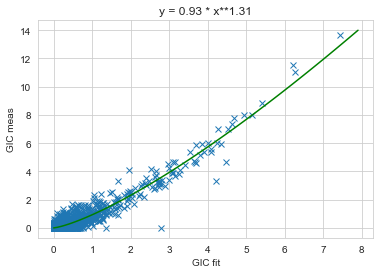

In [26]:
# Check how the values scale between fit and measurements 
# (probably evidence of attenuation from low B sampling rate of minutes)
from scipy.optimize import curve_fit

def correct_gic_fit(x, a, b):
    return a * x**b

gic_fit_p3 = a_SS5*E_p3[0] + b_SS5*E_p3[1]

popt, pcov = curve_fit(correct_gic_fit, np.abs(gic_fit_p3), np.abs(gic_SS5_3))

plt.plot(np.abs(gic_fit_p3), np.abs(gic_SS5_3), 'x')
plt.plot(np.arange(0,8,0.1), correct_gic_fit(np.arange(0,8,0.1), *popt), 'g-')
plt.xlabel("GIC fit")
plt.ylabel("GIC meas")
plt.title("y = {:.2f} * x**{:.2f}".format(*popt))
plt.show()

#### Save files for later use

In [27]:
gic_fit_SS1 = E_t[0] * a_SS1_FUR + E_t[1] * b_SS1_FUR
gic_fit_SS5 = E_t[0] * a_SS5_FUR + E_t[1] * b_SS5_FUR
with open(os.path.join(data_path, "gicfit_SS1_{}-{}.txt".format(readyears_FUR[0],readyears_FUR[1])), 'wb') as f:
    np.save(f, gic_fit_SS1, allow_pickle=False)
with open(os.path.join(data_path, "gicfit_SS5_{}-{}.txt".format(readyears_FUR[0],readyears_FUR[1])), 'wb') as f:
    np.save(f, gic_fit_SS5, allow_pickle=False)

## 3. Create DataFrame of features for machine learning

### OMNI data

Solar wind speed, density and magnetic field variables measured at L1. In the case of OMNI data, the data have been mapped from L1 to very close to the Earth.

The OMNI data was downloaded from https://spdf.gsfc.nasa.gov/pub/data/omni/high_res_omni/. Details on the format can be found here: https://spdf.gsfc.nasa.gov/pub/data/omni/high_res_omni/hroformat.txt

In [52]:
n_seconds = int((datetime(readyears_FUR[1],1,1) - datetime(readyears_FUR[0],1,1)).total_seconds()/60.)
times_all_years = date2num(np.array([datetime(readyears_FUR[0],1,1) + timedelta(minutes=x)
                                     for x in range(n_seconds)]))

In [55]:
omni = []
for year in range(readyears_FUR[0], readyears_FUR[1]):
    print("Reading year {}...".format(year))
    omni_year = np.loadtxt(os.path.join(archive_path,"OMNI","omni_min{}.asc".format(year)))
    omni.append(omni_year)
omni = np.vstack(omni)
omni_time = np.array([date2num(datetime(int(t[0]),1,1) +
                      timedelta(days=int(t[1])-1, hours=int(t[2]), seconds=int(t[3])*60)) for t in omni])
if len(omni_time) != len(times_all_years):
    print("--- PROBLEM! MISSING OMNI DATA.")
bx, by, bz = omni[:,14], omni[:,17], omni[:,18]
speed, density, temperature = omni[:,21], omni[:,25], omni[:,26]

# Replace all the maxima by nans and interpolate over:
print("Replacing empty values with nans...")
for var, fillval in zip([bx, by, bz, speed, density, temperature], [9999, 9999, 9999, 99999, 999, 9999999]):
    inds = var >= fillval
    var[inds] = np.nan
    #var[inds] = np.interp(inds.nonzero()[0], (~inds).nonzero()[0], var[~inds])
btot = np.sqrt(bx*bx + by*by + bz*bz)

print("OMNI data time range from {} to {}.".format(num2date(omni_time[0]).strftime("%Y-%m-%d"), 
                                                   num2date(omni_time[-1]).strftime("%Y-%m-%d")))

Reading year 1995...
Reading year 1996...
Reading year 1997...
Reading year 1998...
Reading year 1999...
Reading year 2000...
Reading year 2001...
Reading year 2002...
Reading year 2003...
Reading year 2004...
Reading year 2005...
Reading year 2006...
Reading year 2007...
Reading year 2008...
Reading year 2009...
Reading year 2010...
Reading year 2011...
Reading year 2012...
Reading year 2013...
Reading year 2014...
Reading year 2015...
Reading year 2016...
Reading year 2017...
Reading year 2018...
Reading year 2019...
Reading year 2020...
Replacing empty values with nans...
OMNI data time range from 1995-01-01 to 2020-12-31.


### FUR Geoelectric Field

In [56]:
# Read FUR geoelectric field data:
all_efield_path = os.path.join(data_path, "efield_fur_39_{}-{}.txt".format(readyears_FUR[0], readyears_FUR[1]))
E_t = np.load(all_efield_path)
exfield_FUR, eyfield_FUR = E_t[0], E_t[1]
E_time_FUR = date2num(np.array([datetime(readyears_FUR[0],1,1) + timedelta(minutes=x) for x in range(E_t.shape[1])]))

# Read horizontal B-field data:
all_bfield_path = os.path.join(data_path, "bfield_fur_{}-{}.txt".format(readyears_FUR[0], readyears_FUR[1]))
Bh_t_FUR = np.load(all_bfield_path)
bxfield_FUR, byfield_FUR = Bh_t_FUR[0], Bh_t_FUR[1]

# Change to nans those parts of the data that aren't present in the data set:
exfield_FUR = np.interp(times_all_years, E_time_FUR, exfield_FUR)
eyfield_FUR = np.interp(times_all_years, E_time_FUR, eyfield_FUR)
exfield_FUR[np.logical_or(times_all_years < E_time_FUR[0], times_all_years > E_time_FUR[-1])] = np.nan
eyfield_FUR[np.logical_or(times_all_years < E_time_FUR[0], times_all_years > E_time_FUR[-1])] = np.nan
bxfield_FUR = np.interp(times_all_years, E_time_FUR, bxfield_FUR)
byfield_FUR = np.interp(times_all_years, E_time_FUR, byfield_FUR)
bxfield_FUR[np.logical_or(times_all_years < E_time_FUR[0], times_all_years > E_time_FUR[-1])] = np.nan
byfield_FUR[np.logical_or(times_all_years < E_time_FUR[0], times_all_years > E_time_FUR[-1])] = np.nan

print("FUR Ex+Ey and Bx+By data time range from {} to {}.".format(num2date(E_time_FUR[0]).strftime("%Y-%m-%d"), 
                                                    num2date(E_time_FUR[-1]).strftime("%Y-%m-%d")))

FUR Ex+Ey and Bx+By data time range from 1995-01-01 to 2020-12-31.


### WIC Geoelectric Field

In [57]:
# Read WIC geoelectric field data:
wic_efield_path = os.path.join(data_path, "efield_wic_39_{}-{}.txt".format(readyears_WIC[0], readyears_WIC[1]))
E_t = np.load(wic_efield_path)
exfield, eyfield = E_t[0], E_t[1]
E_time = date2num(np.array([datetime(readyears_WIC[0],1,1) + timedelta(minutes=x) for x in range(exfield.shape[0])]))

# Read WIC horizontal B-field data:
wic_bfield_path = os.path.join(data_path, "bfield_wic_{}-{}.txt".format(readyears_WIC[0], readyears_WIC[1]))
Bh_t = np.load(wic_bfield_path)
bxfield, byfield = Bh_t[0], Bh_t[1]
    
# Change to nans those parts of the data that aren't present in the data set:
exfield = np.interp(times_all_years, E_time, exfield)
eyfield = np.interp(times_all_years, E_time, eyfield)
exfield[np.logical_or(times_all_years < E_time[0], times_all_years > E_time[-1])] = np.nan
eyfield[np.logical_or(times_all_years < E_time[0], times_all_years > E_time[-1])] = np.nan
bxfield = np.interp(times_all_years, E_time, bxfield)
byfield = np.interp(times_all_years, E_time, byfield)
bxfield[np.logical_or(times_all_years < E_time[0], times_all_years > E_time[-1])] = np.nan
byfield[np.logical_or(times_all_years < E_time[0], times_all_years > E_time[-1])] = np.nan

print("WIC Ex+Ey and Bx+By data time range from {} to {}.".format(num2date(E_time[0]).strftime("%Y-%m-%d"), 
                                                    num2date(E_time[-1]).strftime("%Y-%m-%d")))

WIC Ex+Ey and Bx+By data time range from 2015-01-01 to 2020-12-31.


### Measured DC / GICs

In [58]:
# Load all GIC measurements (compiled beforehand):
df_gic_meas = pd.read_pickle(os.path.join(data_path, 'df_gic_meas.p'))
gic_meas_ss1 = df_gic_meas.loc[num2date(times_all_years[0]):num2date(times_all_years[-1]), 'GIC_SS1'].to_numpy()
gic_meas_SS5 = df_gic_meas.loc[num2date(times_all_years[0]):num2date(times_all_years[-1]), 'GIC_SS5'].to_numpy()

In [59]:
gics_ss1_path = os.path.join(data_path, "gicfit_SS1_{}-{}.txt".format(readyears_FUR[0], readyears_FUR[1]))
gic_fit_SS1 = np.load(gics_ss1_path)
gics_SS5_path = os.path.join(data_path, "gicfit_SS5_{}-{}.txt".format(readyears_FUR[0], readyears_FUR[1]))
gic_fit_SS5 = np.load(gics_SS5_path)

### Plot the time ranges

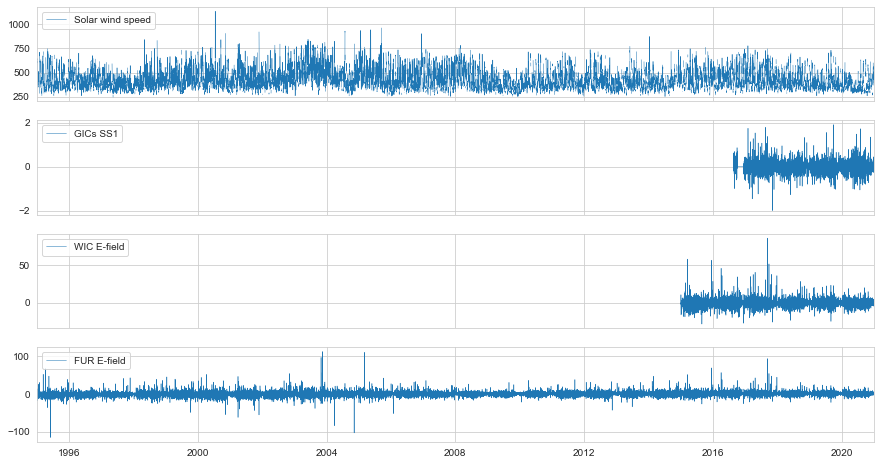

In [60]:
%matplotlib inline
fig, axes = plt.subplots(4,1, figsize=(15, 8), sharex=True)
skip = 600
axes[0].plot_date(times_all_years[::skip], speed[::skip], '-', lw=0.5, label="Solar wind speed")
axes[0].legend(loc="upper left")
axes[1].plot_date(times_all_years[::skip], gic_meas_ss1[::skip], '-', lw=0.5, label="GICs SS1")
axes[1].legend(loc="upper left")
axes[2].plot_date(times_all_years[::skip], exfield[::skip], '-', lw=0.5, label="WIC E-field")
axes[2].legend(loc="upper left")
axes[3].plot_date(times_all_years[::skip], exfield_FUR[::skip], '-', lw=0.5, label="FUR E-field")
axes[3].legend(loc="upper left")
axes[3].set_xlim([datetime(readyears_FUR[0],1,1), datetime(readyears_FUR[1],1,1)])
plt.show()

### Create DataFrame object as Training Data

In [61]:
# Pack all values into a DataFrame
pickled_data_path = os.path.join(data_path,'df_features.p')
timing_start = time.time()
df_time = [num2date(x).replace(tzinfo=None) for x in times_all_years]
print("Creating DataFrame with features...")

# MAIN FEATURES
df_features = pd.DataFrame({'time': df_time, 
                            # Solar wind data
                            'bx': bx, 'by': by, 'bz': bz, 'btot': btot,
                            'speed': speed, 'density': density, 'temp': temperature,
                            # Geoelectric field from WIC
                            'Ex': exfield, 'Ey': eyfield,
                            # Geoelectric field from FUR
                            'Ex_FUR': exfield_FUR, 'Ey_FUR': eyfield_FUR,
                            # Magnetic field from WIC
                            'Bx_WIC': bxfield, 'By_WIC': byfield,
                            # Magnetic field from FUR
                            'Bx_FUR': bxfield_FUR, 'By_FUR': byfield_FUR,})
df_features = df_features.set_index('time')
df_features.to_pickle(pickled_data_path)

# GIC DATA IN SAME TIME FRAME
pickled_data_path_gic = os.path.join(data_path,'df_features_gic.p')
df_features_gic = pd.DataFrame({'time': df_time,
                                # GICS - measured and from fit
                                'GIC_SS1': gic_meas_ss1, 'GIC_SS5': gic_meas_SS5, 
                                'GIC_fit_SS1': gic_fit_SS1, 'GIC_fit_SS5': gic_fit_SS5})
df_features_gic = df_features_gic.set_index('time')
df_features_gic.to_pickle(pickled_data_path_gic)
print("Completed.")

timing_end = time.time()
print("Creating DataFrame for {} data points took {:.1f} minutes.".format(len(times_all_years), (timing_end-timing_start)/60.))

df_features

Creating DataFrame with features...
Completed.
Creating DataFrame for 13675680 data points took 3.1 minutes.


,bx,by,bz,btot,speed,density,temp,Ex,Ey,Ex_FUR,Ey_FUR,Bx_WIC,By_WIC,Bx_FUR,By_FUR
time,,,,,,,,,,,,,,,
1995-01-01 00:00:00,0.19,1.13,-0.70,1.342758,NaN,NaN,9999999.0,NaN,NaN,-3.276309,0.382046,NaN,NaN,-83.108473,-529.800547
1995-01-01 00:01:00,0.19,1.13,-0.70,1.342758,NaN,NaN,9999999.0,NaN,NaN,-3.682864,0.711965,NaN,NaN,-83.108473,-529.800547
1995-01-01 00:02:00,0.24,1.23,-0.72,1.445303,NaN,NaN,9999999.0,NaN,NaN,-3.105882,0.358401,NaN,NaN,-83.108473,-529.800547
1995-01-01 00:03:00,0.19,1.25,-0.67,1.430909,NaN,NaN,9999999.0,NaN,NaN,-4.182004,0.741129,NaN,NaN,-83.108473,-529.800547
1995-01-01 00:04:00,-0.14,1.09,-0.54,1.224459,NaN,NaN,9999999.0,NaN,NaN,-6.552872,0.321476,NaN,NaN,-83.108473,-530.800547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 23:55:00,0.35,-1.35,1.98,2.421859,369.4,4.11,29629.0,2.144818,0.274118,2.720929,0.347886,3.430323,156.31387,83.151527,634.199453
2020-12-31 23:56:00,1.87,-1.15,1.08,2.446589,362.5,4.49,38832.0,2.130289,1.406948,2.921611,1.756880,3.090323,156.45387,82.731527,634.359453
2020-12-31 23:57:00,0.86,-1.37,1.91,2.502918,363.9,4.44,35270.0,1.266964,0.552697,1.863064,0.711957,3.100323,156.30387,82.731527,634.209453


In [31]:
df_features_gic

,GIC_SS1,GIC_SS5,GIC_fit_SS1,GIC_fit_SS5
time,,,,
1995-01-01 00:00:00,NaN,NaN,-0.111342,0.006673
1995-01-01 00:01:00,NaN,NaN,-0.116147,0.023185
1995-01-01 00:02:00,NaN,NaN,-0.105670,0.006116
1995-01-01 00:03:00,NaN,NaN,-0.134036,0.022590
1995-01-01 00:04:00,NaN,NaN,-0.236811,-0.011229
...,...,...,...,...
2020-12-31 23:55:00,0.190569,0.016477,0.113684,0.031388
2020-12-31 23:56:00,0.277250,0.125858,0.166192,0.110504
2020-12-31 23:57:00,0.263885,0.029965,0.092952,0.047794
